In [1]:
%load_ext autoreload
%autoreload 2
import gust  # library for loading graph data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import time

torch.set_default_tensor_type('torch.cuda.FloatTensor')
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load the dataset using `gust` library
# graph.standardize() makes the graph unweighted, undirected and selects
# the largest connected component
# graph.unpack() returns the necessary vectors / matrices

A, X, _, y = gust.load_dataset('cora').standardize().unpack()
# A - adjacency matrix 
# X - attribute matrix - not needed
# y - node labels

if (A != A.T).sum() > 0:
    raise RuntimeError("The graph must be undirected!")

if (A.data != 1).sum() > 0:
    raise RuntimeError("The graph must be unweighted!")

In [3]:
num_nodes = A.shape[0]
num_edges = A.sum()

# Convert adjacency matrix to a CUDA Tensor
adj = torch.FloatTensor(A.toarray()).cuda()

In [4]:
torch.manual_seed(123)
# Define the embedding matrix
embedding_dim = 64
emb = nn.Parameter(torch.empty(num_nodes, embedding_dim).normal_(0.0, 1.0))

# Initialize the bias
# The bias is initialized in such a way that if the dot product between two embedding vectors is 0 
# (i.e. z_i^T z_j = 0), then their connection probability is sigmoid(b) equals to the 
# background edge probability in the graph. This significantly speeds up training
edge_proba = num_edges / (num_nodes**2 - num_nodes)
bias_init = np.log(edge_proba / (1 - edge_proba))
b = nn.Parameter(torch.Tensor([bias_init]))

# Regularize the embeddings but don't regularize the bias
# The value of weight_decay has a significant effect on the performance of the model (don't set too high!)
opt = torch.optim.Adam([
    {'params': [emb], 'weight_decay': 1e-7},
    {'params': [b]}],
    lr=1e-2)

In [14]:
# There are many ways to compute the loss / negative log-likelihood of the model
def compute_loss_v1(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    loss = F.binary_cross_entropy_with_logits(logits, adj, reduction='none')
    # Since we consider graphs without self-loops, we don't want to compute loss
    # for the diagonal entries of the adjacency matrix.
    # This will kill the gradients on the diagonal.
    loss[np.diag_indices(adj.shape[0])] = 0.0
    return loss.mean()

# This function uses the torch.distributions module
def compute_loss_v2(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    distribution = dist.Bernoulli(logits=logits)
    log_probas = distribution.log_prob(adj)
    log_probas[np.diag_indices(adj.shape[0])] = 0.0
    loss = -log_probas.mean()
    return loss

# Here we compute the loss manually
def compute_loss_v3(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    log_probas = adj * logits - F.softplus(logits)
    log_probas[np.diag_indices(adj.shape[0])] = 0.0
    loss = -log_probas.mean()
    return loss


# Approach 1: Naive apporach
def compute_loss_d1(adj, emb, b=0.0): 
    """Compute the rdf distance of the Bernoulli model."""
    # Initialization
    start_time = time.time()
    N,d=emb.shape
    squared_euclidian = torch.zeros(N,N).cuda()
    gamma= 0.1
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for initialization = {duration:.5f}')
    # Compute squared euclidian
    start_time = time.time()
    for index, embedding in enumerate(emb):
        sub =  embedding-emb + 10e-9
        squared_euclidian[index,:]= torch.sum(torch.pow(sub,2),1)
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for euclidian = {duration:.5f}')
    # Compute exponentianl
    start_time = time.time()
    radial_exp = torch.exp (-gamma * torch.sqrt(squared_euclidian))
    loss = F.binary_cross_entropy(radial_exp, adj, reduction='none')
    loss[np.diag_indices(adj.shape[0])] = 0.0
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for loss  = {duration:.5f}')
    return loss.mean()


# Approach 2: Use the squareform function
def compute_loss_d2(adj, emb, b=0.0): 
    # Initialization
    start_time = time.time()
    N,d=emb.shape
    squared_euclidian = torch.zeros(N,N).cuda()
    gamma= 0.1
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for initialization = {duration:.5f}')
    # Compute squared euclidian
    start_time = time.time()
    euclidian= torch.nn.functional.pdist(emb, p=2)
    euclidian_np= torch.from_numpy(euclidian.cpu().detach().numpy())
    matrix_euclidian_np = squareform(euclidian_np)
    matrix_euclidian = torch.from_numpy(matrix_euclidian_np).cuda()
    end_time= time.time()
    #print(f' Time for euclidian = {duration:.5f}')
    # Compute exponentianl
    start_time = time.time()
    radial_exp = torch.exp (-gamma * matrix_euclidian)
    loss = F.binary_cross_entropy(radial_exp, adj, reduction='none')
    loss[np.diag_indices(adj.shape[0])] = 0.0
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for loss  = {duration:.5f}')

    return loss.mean()



# Approach 3: Build the matrix from scratch
def compute_loss_d3(adj, emb, b=0.0): 
    # Initialization
    start_time = time.time()
    N,d=emb.shape
    squared_euclidian = torch.zeros(N,N).cuda()
    gamma= 0.1
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for initialization = {duration:.5f}')
    # Compute squared euclidian
    start_time = time.time()
    euclidian= torch.nn.functional.pdist(emb, p=2)
    start= 0
    for i in range(N):
        end = start + ( N - i -1)
        elem = len(euclidian[start:end])
        #print(f' start = {start:d}, end = {end:d},elements = {elem:d} ')
        squared_euclidian[i,i+1:] = euclidian[start:end] 
        squared_euclidian[i+1:,i] = euclidian[start:end] 
        start += (N-i-1) 
        end_time= time.time()
    #print(f' Time for euclidian = {duration:.5f}')
    # Compute exponentianl
    start_time = time.time()
    radial_exp = torch.exp (-gamma * squared_euclidian)
    loss = F.binary_cross_entropy(radial_exp, adj, reduction='none')
    end_time= time.time()
    duration= end_time -start_time
    #print(f' Time for loss  = {duration:.5f}')
    return loss.mean()

# Approach 4: Hold only a part of A 
def compute_loss_d4(adj, emb, b=0.1): 
    # Initialization
    N,d=emb.shape
    gamma= 0.1
    # Compute the rdf distance
    euclidian= torch.nn.functional.pdist(emb, p=2)
    radial_exp = torch.exp (-gamma * euclidian)
    # Extract the elements of the upper triangular matrix without the diagonal elements
    ind=torch.triu_indices(N,N,offset=1)
    labels = adj[ind[0].cpu().detach().numpy(),ind[1].cpu().detach().numpy()]
    # Compute the loss function
    loss = F.binary_cross_entropy(radial_exp, labels, reduction='none')
    return loss.mean()

# Approach 4: Hold only a part of A 
def compute_loss_d5(adj, emb, b=0.1): 
    # Initialization
    N,d=emb.shape
    gamma= 0.1
    # Compute the rdf distance
    euclidian= torch.nn.functional.pdist(emb, p=2).cpu()
    radial_exp = torch.exp (-gamma * euclidian).cpu()
    # Extract the elements of the upper triangular matrix without the diagonal elements
    ind=torch.triu_indices(N,N,offset=1).cpu()
    labels = adj[ind[0],ind[1]]
    # Compute the loss function
    loss = F.binary_cross_entropy(radial_exp.cuda(), labels.cuda(), reduction='none')
    return loss.mean()

def compute_loss_KL(adj, emb, b=0.0):
    degree= torch.from_numpy(A.sum(axis=1))
    inv_degree=torch.diagflat(1/degree).cuda()
    P = inv_degree.mm(adj) 
    loss = -(P*torch.log( 10e-9+ F.softmax(emb.mm(emb.t() ),dim=1,dtype=torch.float)))
    return loss.mean()



# In general, it's very important to compute all the losses in a numerically stable way
# (e.g. using the log-sum-exp trick) or use existing library functions

In [15]:
max_epochs = 5000
display_step = 250


compute_loss = compute_loss_KL

for epoch in range(max_epochs):
    opt.zero_grad()
    loss = compute_loss(adj, emb, b)
    loss.backward()
    opt.step()
    # Training loss is printed every display_step epochs
    if epoch % display_step == 0:
        print(f'Epoch {epoch:4d}, loss = {loss.item():.5f}')
        
        
cora_KL = emb

Epoch    0, loss = 0.00097
Epoch  250, loss = 0.00097
Epoch  500, loss = 0.00097
Epoch  750, loss = 0.00097
Epoch 1000, loss = 0.00097
Epoch 1250, loss = 0.00097
Epoch 1500, loss = 0.00097
Epoch 1750, loss = 0.00097
Epoch 2000, loss = 0.00097
Epoch 2250, loss = 0.00097
Epoch 2500, loss = 0.00097
Epoch 2750, loss = 0.00097
Epoch 3000, loss = 0.00097
Epoch 3250, loss = 0.00097
Epoch 3500, loss = 0.00097
Epoch 3750, loss = 0.00097
Epoch 4000, loss = 0.00097
Epoch 4250, loss = 0.00097
Epoch 4500, loss = 0.00097
Epoch 4750, loss = 0.00097


In [7]:
# We need to transform 64-dimensional embedding into 2d for visualization
# For this we can either use t-SNE from scikit-learn or UMAP
# umap package can be installed with `pip install umap`

# from sklearn.manifold import TSNE
# from umap import UMAP as TSNE
from sklearn.manifold import TSNE

def visualize(emb, y):
    emb = emb.cpu().detach().numpy()
    tsne = TSNE()
    vis = tsne.fit_transform(emb)
    plt.figure(figsize=[10, 8])
    plt.scatter(vis[:, 0], vis[:, 1], c=palette[y], s=20, alpha=0.8)
    
# Alternative to the default seaborn palette
palette = np.array(sns.color_palette('muted', n_colors=len(np.unique(y))))

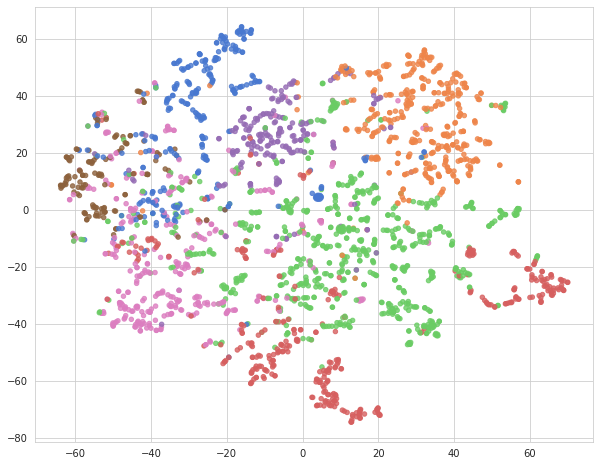

In [8]:
visualize(emb, y)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

split_ratio = 0.2

label=y

h_datasets = ['cora sigmoid', 'cora KL'] 

datasets = [cora_sigmoid, cora_KL]

h_classifiers = ["Decision Tree","Nearest Neighbors", "Linear SVM"
         ]

classifiers = [ 
    DecisionTreeClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear")]



for i, data in enumerate(datasets):
    features = data.cpu().detach().numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size= split_ratio)
    for j, model in enumerate(classifiers):
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        print ( h_datasets[i], h_classifiers[j])
        print(score)

NameError: name 'cora_sigmoid' is not defined

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score

if type(emb) is not np.ndarray: 
    emb = emb.cpu().detach().numpy()

X, labels_true = emb, y
n_cluster = len(set(labels_true))
init = np.zeros((n_cluster,embedding_dim))
for i in range(n_cluster):
    init[i,:] = X[np.where(labels_true==i)].mean(axis=0)
kmeans =  KMeans(n_clusters=n_cluster, random_state=0, init= init).fit(X)

labels = kmeans.labels_

print("Mutual Information: %0.3f"
      % mutual_info_score(labels_true, labels))
print("Normalized Mutual Information: %0.3f"
      % normalized_mutual_info_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels))

/nfs/students/winter-term-2019/project_5/cziakas/miniconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/nfs/students/winter-term-2019/project_5/cziakas/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/nfs/students/winter-term-2019/project_5/cziakas/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual Information: 0.761
Normalized Mutual Information: 0.412
Adjusted Mutual Information: 0.406


In [11]:
from sklearn.manifold import TSNE
palette = np.array(sns.color_palette('muted', n_colors=len(np.unique(y))))
tsne = TSNE()
vis = tsne.fit_transform(emb)

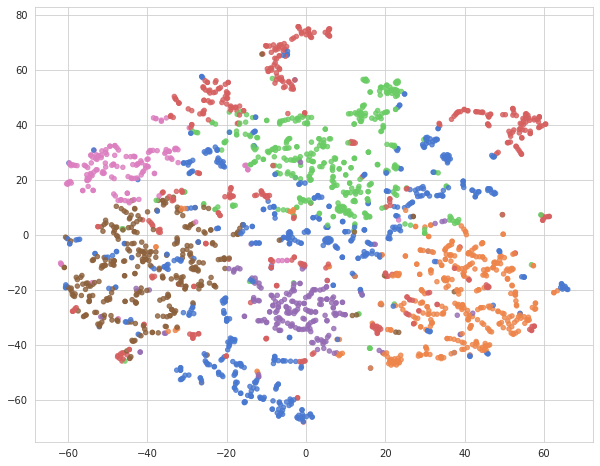

In [12]:
plt.figure(figsize=[10, 8])
plt.scatter(vis[:, 0], vis[:, 1], c=palette[labels], s=20, alpha=0.8)

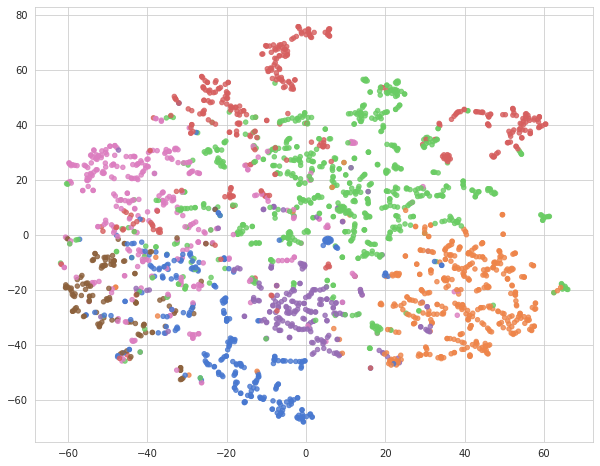

In [13]:
plt.figure(figsize=[10, 8])
plt.scatter(vis[:, 0], vis[:, 1], c=palette[labels_true], s=20, alpha=0.8)

# Models that need to be implemented
## 1. Bernoulli models
Learn embeddings by maximizing the objective 
$$\max_{Z \in \mathbb{R}^{N \times D}} \log p(A | Z)$$
where
$$p(A | Z) = \prod_{i < j} Bernoulli(A_{ij}| f(z_i, z_j))$$

- Sigmoid model
$$f(z_i, z_j) = \sigma(z_i^T z_j + b)$$

$\;$
- Distance-based model #1
$$f(z_i, z_j) = \exp(-\gamma||z_i^T - z_j||)$$

$\;$
- Distance-based model #2 (https://arxiv.org/pdf/1905.13177.pdf, Equation 6)
$$f(z_i, z_j) = \sigma(C(1 - ||z_i^T - z_j||))$$
they use $C = 10$ in the paper.

## 2. Categorical cross-entropy models
Learn embeddings by optimizing the objective 
$$\min_{Z \in \mathbb{R}^{N \times D}} \mathbb{KL}(M || \operatorname{softmax}(Z Z^T))$$
note that we don't need to add a bias term here since $\operatorname{softmax}(x) = \operatorname{softmax}(x + c)$ for any vector $x$ and constant $c$.

Choices for $M$:
- Transition matrix $M = P = D^{-1}A$, where $D_{ii} = \sum_{ij} A_{ij}$, $D_{ij} = 0$ if $i \ne j$.
- Personalized PageRank matrix $M = (I - \alpha P)^{-1}$(https://arxiv.org/pdf/1803.04742.pdf)
- Finite-step transition matrix (i.e. average of powers of the transition matrix) $\frac{1}{T} \sum_{t=1}^{T} P^{t}$ (https://arxiv.org/pdf/1702.05764.pdf). This is equivalent to the popular DeepWalk method (https://arxiv.org/abs/1403.6652)

## Different model variants for (1) and (2)

You should consider two options for modeling the embeddings:
 - Learning $Z \in \mathbb{R}^{N \times D}$, get a "score" as $z_i^T z_j$
 - Learning $Z \in \mathbb{R}^{N \times D}$ and $W \in \mathbb{R}^{D \times D}$, get a "score" as $z_i^T W z_j$
 
The first option might not be capable to model networks with heterophily, but the second option requires learning more parameters. You should implement both version and see which works better.

## 3. Methods based on SVD / Matrix factorization
You obtain embeddings in these methods by performing SVD / eigendecomposition (no need to perform gradient descent here).

- NetMF - see Algorithm 3 & 4 in (https://arxiv.org/pdf/1710.02971.pdf)
- Spectral clustering - see MMDS lecture

In [ ]:
# The error for the second approach
compute_loss = compute_loss_d2
max_epochs = 5000
display_step = 250

for epoch in range(max_epochs):
    opt.zero_grad()
    loss = compute_loss(adj, emb, b)
    loss.backward()
    opt.step()
    # Training loss is printed every display_step epochs
    if epoch % display_step == 0:
        print(f'Epoch {epoch:4d}, loss = {loss.item():.5f}')

In [ ]:
# The error for the third approach
compute_loss = compute_loss_d3
max_epochs = 5000
display_step = 250

for epoch in range(max_epochs):
    opt.zero_grad()
    loss = compute_loss(adj, emb, b)
    loss.backward()
    opt.step()
    # Training loss is printed every display_step epochs
    if epoch % display_step == 0:
        print(f'Epoch {epoch:4d}, loss = {loss.item():.5f}')

In [ ]:
# The error for the fourth approach
compute_loss = compute_loss_d4
max_epochs = 5000
display_step = 250

for epoch in range(max_epochs):
    opt.zero_grad()
    loss = compute_loss(adj, emb, b)
    loss.backward()
    opt.step()
    # Training loss is printed every display_step epochs
    if epoch % display_step == 0:
        print(f'Epoch {epoch:4d}, loss = {loss.item():.5f}')

In [ ]:
# The second apporach with the squareform function 
from scipy.spatial.distance import squareform
start_time = time.time()
N=1000
emb= torch.randn(N, N).cuda()
euclidian= torch.nn.functional.pdist(emb, p=2)
euclidian_np= torch.from_numpy(euclidian.cpu().detach().numpy())
matrix_euclidian_np = squareform(euclidian_np)
matrix_euclidian = torch.from_numpy(matrix_euclidian_np).cuda()
end_time= time.time()
duration= end_time -start_time
duration

In [ ]:
# The third apporach
start_time = time.time()
N=1000
emb= torch.randn(N, N).cuda()
euclidian= torch.nn.functional.pdist(emb, p=2)
start= 0
for i in range(N):
    end = start + ( N - i -1)
    elem = len(euclidian[start:end])
    #print(f' start = {start:d}, end = {end:d}, elements = {elem:d} ')
    matrix_euclidian[i,i+1:] = euclidian[start:end] 
    matrix_euclidian[i+1:,i] = euclidian[start:end] 
    start += (N-i-1) 
#print(matrix_euclidian)    
end_time= time.time()
end_time -start_time

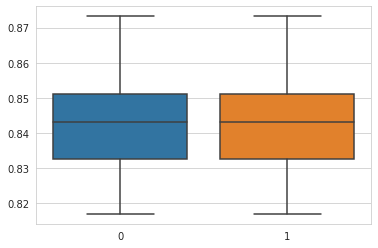

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

split_ratio = 0.2

label=y


n_iterations = 10
n_models =2
total_scores = []

if type(emb) is not np.ndarray: 
    emb = emb.cpu().detach().numpy()
for i in range(n_models):
    score_model= np.zeros(n_iterations)
    for i in range(n_iterations):
        features = emb
        X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size= split_ratio, random_state=i) 
        model = KNeighborsClassifier(3).fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        score_model[i]= score
    total_scores.append(score_model)

sns.boxplot(data=total_scores)